In [1]:
from typing import Callable

from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole

import networkx as nx
import matplotlib.pyplot as plt

import torch
from torch_geometric.utils import to_dense_adj

/home/adrien/gnn-dynamical-systems/.env/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Loading MoleculeNet Data

In [2]:
# Downloading the ESOL dataset from the MoleculeNet paper
from torch_geometric.datasets import MoleculeNet
from torch_geometric.loader import DataLoader
data = MoleculeNet(root = "esol_dataset/", name ="ESOL")

## Utils functions

In [3]:
def draw_molecule(index: int) -> None:  
    m = Chem.MolFromSmiles(data[index].smiles)
    display(m)

In [4]:
def get_adj(index: int) -> torch.FloatTensor:
    return to_dense_adj(data[index].edge_index)[0]


In [5]:
def draw_graph(adj_matrix: torch.FloatTensor, 
               node_weights: torch.FloatTensor | None = None,
               *,
               color_normalization: Callable[[float],float]| None = None) -> None:
    G = nx.from_numpy_array(adj_matrix.numpy())
    if node_weights is None:
        nx.draw(G)
    else:
        if color_normalization is None:
            color_normalization = lambda x: (x-torch.min(node_weights))/(torch.max(node_weights)-torch.min(node_weights))

        nx.draw(G, node_color = [(0,color_normalization(x),color_normalization(x)) for x in node_weights.numpy()])
    plt.show()

In [12]:
def draw_matrix(m: torch.FloatTensor) -> None:
    fig,_ = plt.subplots()
    im = plt.imshow(m.numpy())
    plt.colorbar(im)
    plt.show()

In [10]:
def normalized_adj_matrix(index: int) -> torch.FloatTensor:
    adj_matrix: torch.FloatTensor = get_adj(index)
    D = torch.sum(adj_matrix, dim=0)
    inv_root_D = torch.diag(1/torch.sqrt(D))

    return inv_root_D@adj_matrix@inv_root_D

## Spectral analysis of molecules

### Adjency graph spectrum


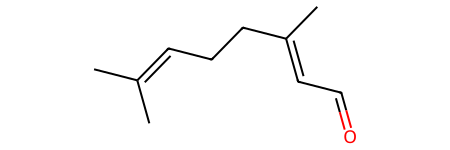

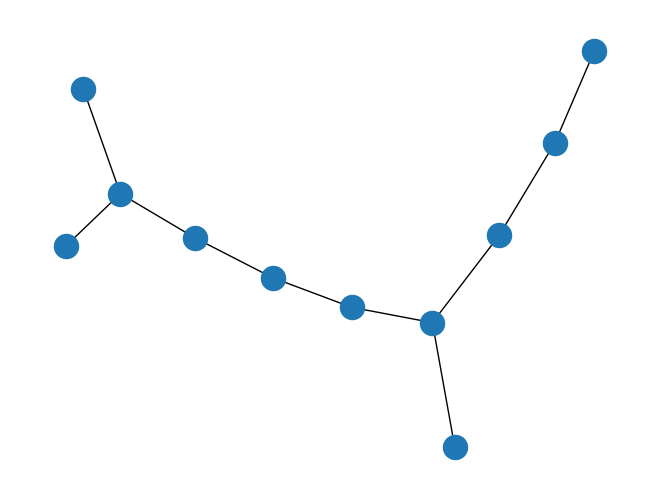

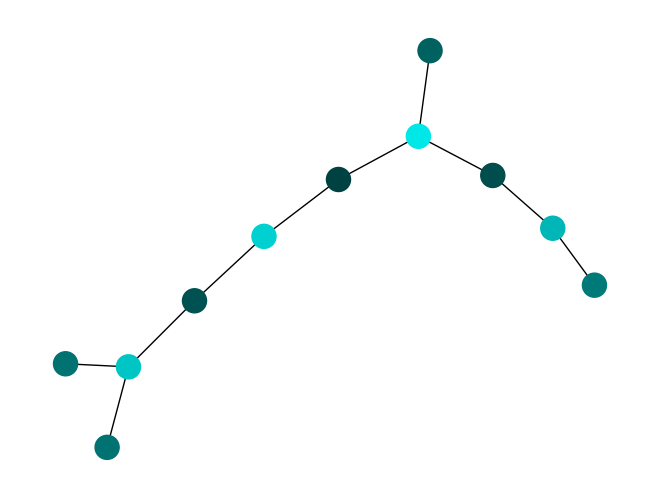

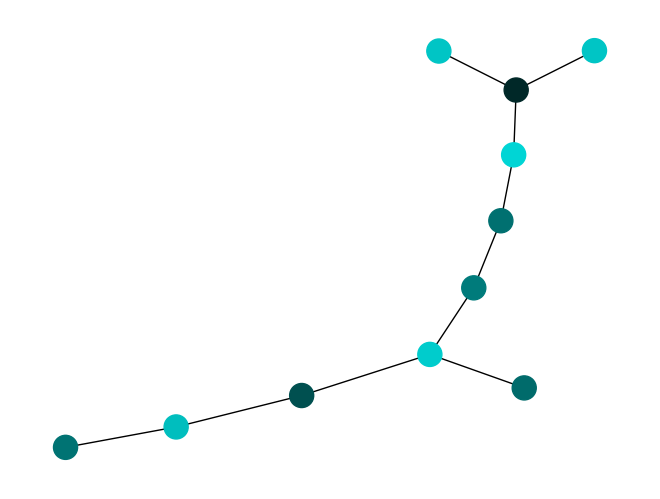

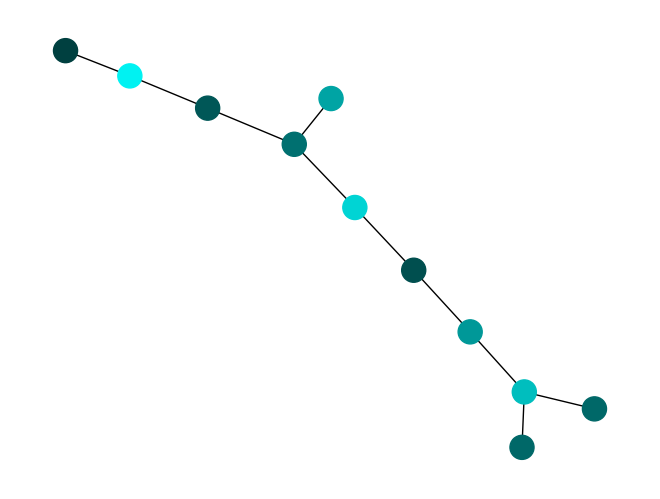

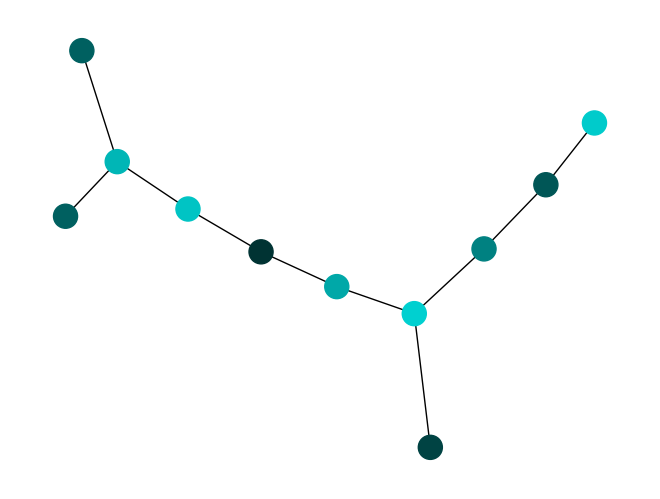

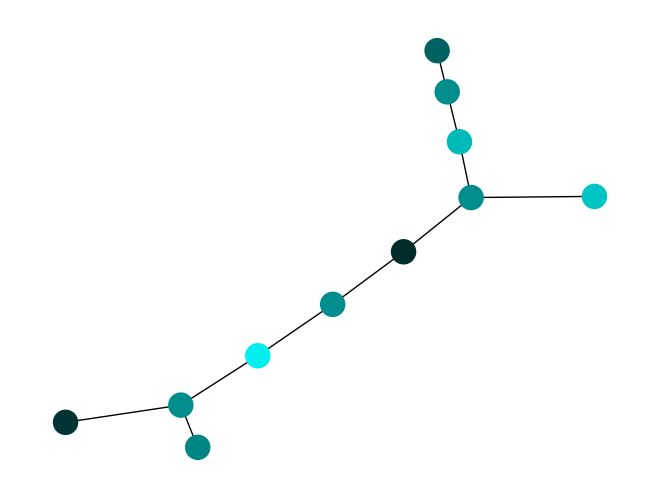

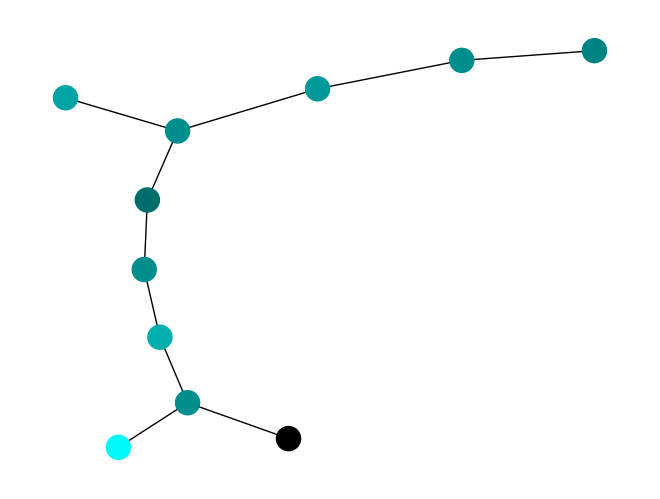

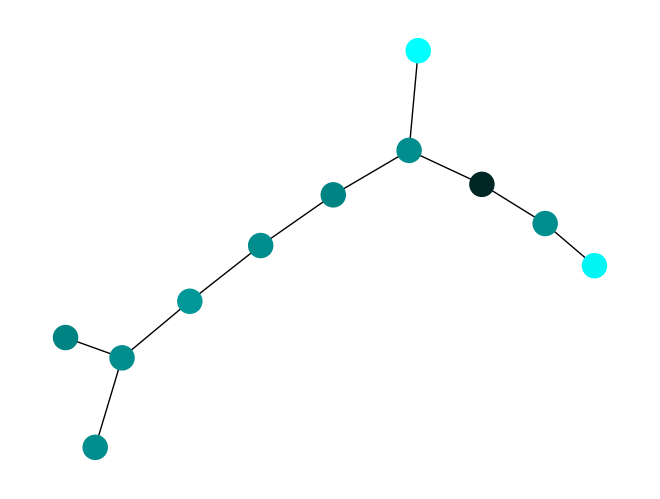

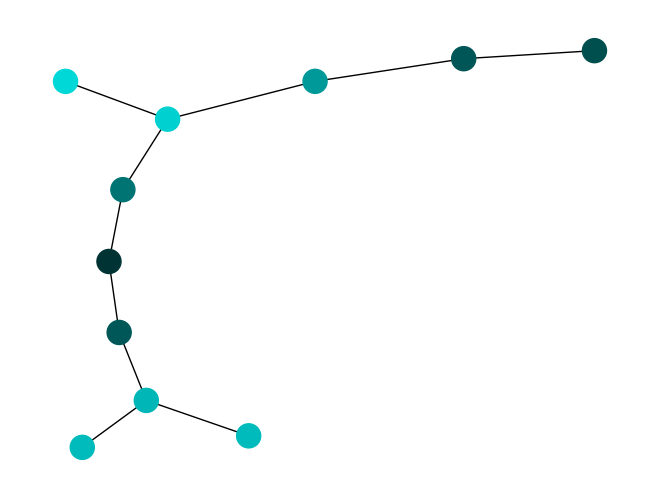

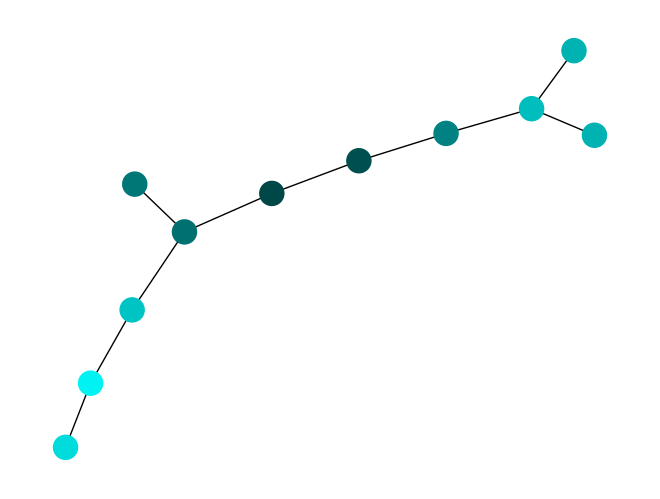

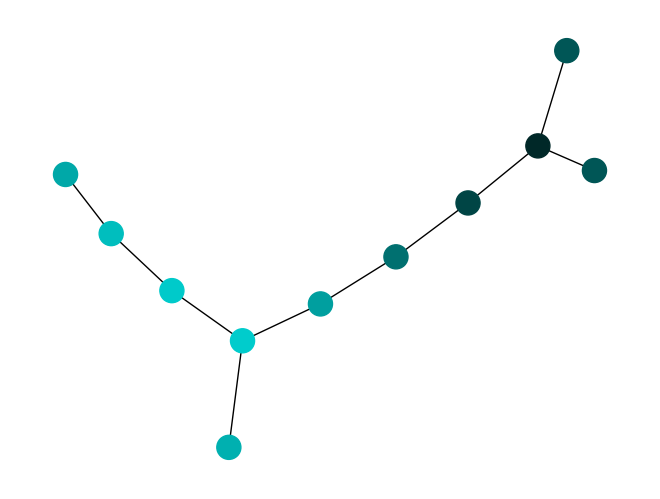

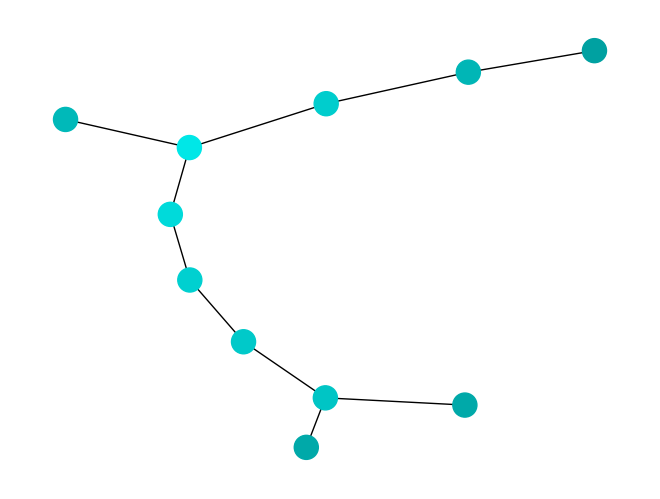

In [8]:
MOLECULE_INDEX = 2

adj_matrix = get_adj(MOLECULE_INDEX)
draw_molecule(MOLECULE_INDEX)
draw_graph(adj_matrix)

eigenvectors = torch.linalg.eigh(adj_matrix).eigenvectors
for i in range(len(eigenvectors)):
    draw_graph(adj_matrix, 
               eigenvectors[:,i], 
               color_normalization= lambda x: (x-torch.min(eigenvectors))/(torch.max(eigenvectors)-torch.min(eigenvectors)))



### Comparison with normalized adjency spectrum

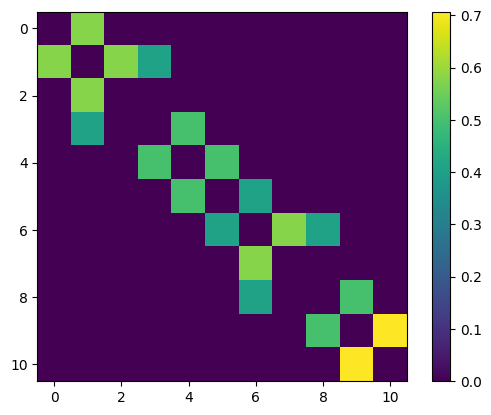

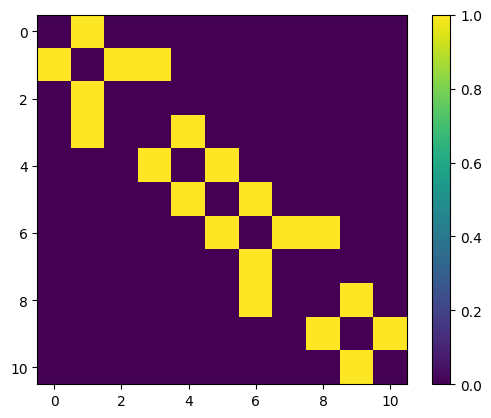

In [15]:
draw_matrix(normalized_adj_matrix(MOLECULE_INDEX))
draw_matrix(get_adj(MOLECULE_INDEX))

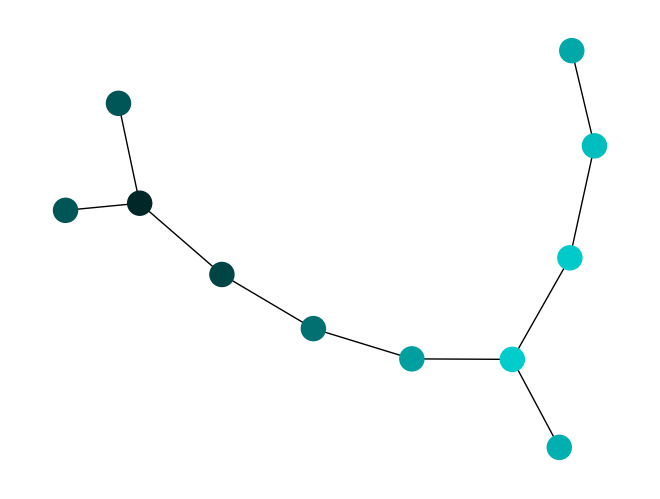

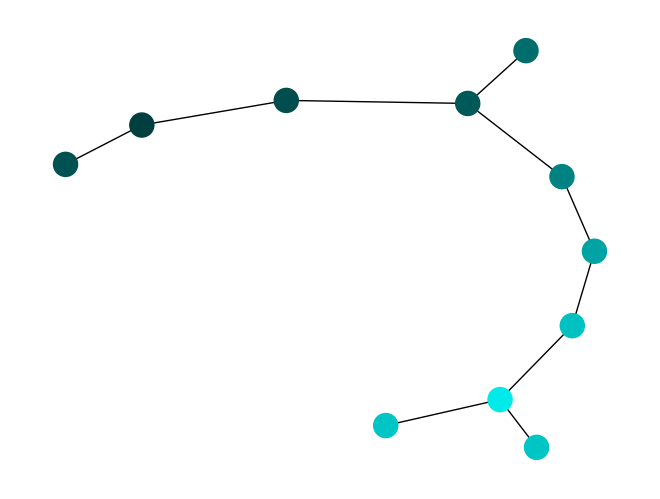

In [18]:
EIGENVECTOR_INDEX = 9

norm_adj_matrix = normalized_adj_matrix(MOLECULE_INDEX)

eigenvectors = torch.linalg.eigh(adj_matrix).eigenvectors
normalized_eigenvectors = torch.linalg.eigh(norm_adj_matrix).eigenvectors

# ADJENCY
draw_graph(adj_matrix,
           eigenvectors[:,EIGENVECTOR_INDEX], 
           color_normalization= lambda x: (x-torch.min(eigenvectors))/(torch.max(eigenvectors)-torch.min(eigenvectors)))

# NORMALIZED ADJENCY
draw_graph(norm_adj_matrix,
           normalized_eigenvectors[:,EIGENVECTOR_INDEX], 
           color_normalization= lambda x: 
                                    (x-torch.min(normalized_eigenvectors))/(torch.max(normalized_eigenvectors)-torch.min(normalized_eigenvectors)))



## Fourier transform on graph

In [19]:
def graph_fourier_transform(adj: torch.FloatTensor, signal: torch.FloatTensor) -> torch.FloatTensor:
    eigenvectors = torch.linalg.eigh(adj).eigenvectors
    return eigenvectors.T@signal


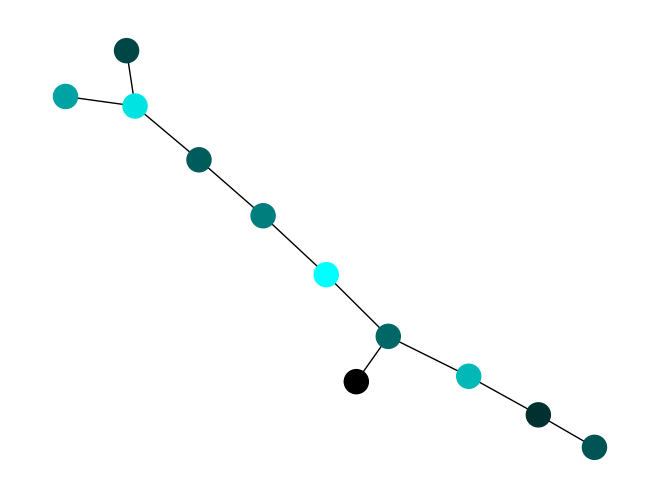

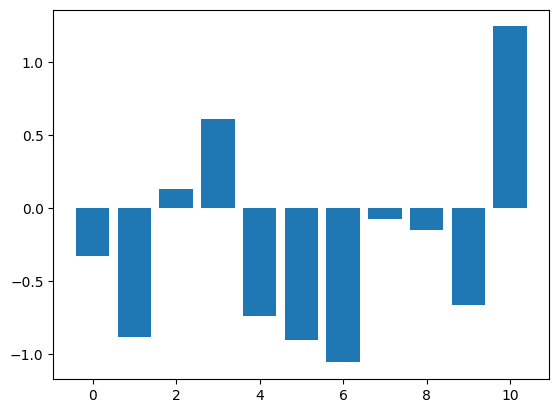

In [24]:

signal = torch.randn((len(adj_matrix),))
fourier_signal = graph_fourier_transform(adj_matrix,signal)

draw_graph(adj_matrix,signal)
plt.bar(list(range(len(signal))), fourier_signal.numpy())
plt.show()

## Diffusion on Graphs